<a href="https://colab.research.google.com/github/BrianGirardiRice/Public/blob/main/HackerIden.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
sys.meta_path[:] = [f for f in sys.meta_path if "DaskFinder" not in str(f)]

!pip install numpy==1.24.3
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    import cirq

    print("installed cirq.")

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
import random



installing cirq...
installed cirq.


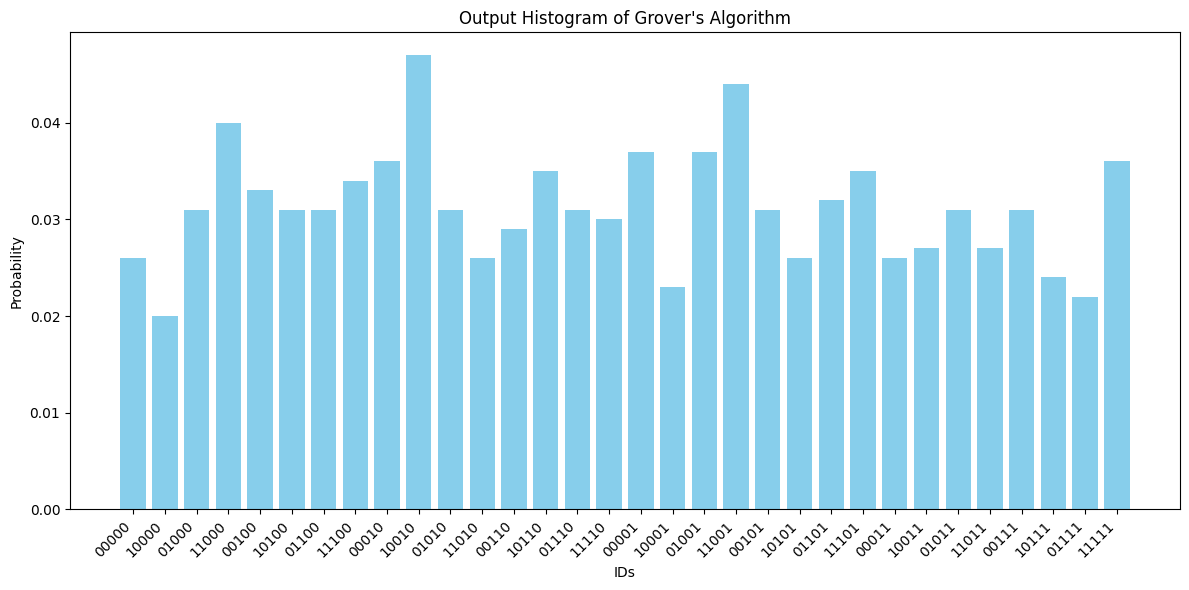

Most common results:
10010: 47 times
11001: 44 times
11000: 40 times
01001: 37 times
00001: 37 times
00010: 36 times
11111: 36 times
10110: 35 times
11101: 35 times
11100: 34 times
                          ┌──┐           ┌──┐   ┌──┐                       ┌──┐       ┌──┐       ┌───┐
0: ───────────────H───@────@─────────@────@───────@─────────────────────────@─────H────X─────────────────────────────────────@───X───H───────M('result')───
                      │    │         │    │       │                         │                                                │               │
1: ───────────────H───┼────┼─────@───@────┼@──────┼─────────────────────────@─────X─────@─────────@──────X───H───X───────────@───X───H───────M─────────────
                      │    │     │   │    ││      │                         │           │         │                          │               │
2: ───────────────H───@────┼X────┼───┼────┼┼──────┼────────────@───X───X────┼@─────────@┼────X────┼@─────────@───H───X

In [11]:
# Form circuit
qubits = [cirq.LineQubit(i) for i in range(5)]  # 5 input qubits + 1 ancilla
ancillas = [cirq.LineQubit(i+5) for i in range(8)]
final = cirq.NamedQubit("Final Ancilla")

def oracle():



    # NOT 1 or NOT 3 or Not 4 or Not 5 = not (1 and 3 and 4 and 5)
    yield cirq.X(ancillas[0])
    yield cirq.X(ancillas[0]).controlled_by(qubits[0], qubits[2], qubits[3], qubits[4])

    # 1 or 2
    yield cirq.CX(qubits[0], ancillas[1])
    yield cirq.CX(qubits[1], ancillas[1])
    yield cirq.TOFFOLI(qubits[0], qubits[1], ancillas[1])  # If both

    # 1 or not 5
    yield cirq.X(qubits[4])
    yield cirq.CX(qubits[0], ancillas[1])
    yield cirq.CX(qubits[4], ancillas[1])
    yield cirq.TOFFOLI(qubits[0], qubits[3], ancillas[2])  # If both
    yield cirq.X(qubits[4])

    #3 or 4 or 5 = not (not 3 and not 4 and not 5)
    yield cirq.X(ancillas[3])
    yield cirq.X(qubits[2])
    yield cirq.X(qubits[3])
    yield cirq.X(qubits[4])
    yield cirq.X(ancillas[3]).controlled_by(qubits[2], qubits[3], qubits[4])
    yield cirq.X(qubits[2])
    yield cirq.X(qubits[3])
    yield cirq.X(qubits[4])

    #2 or 4
    yield cirq.CX(qubits[1], ancillas[4])
    yield cirq.CX(qubits[3], ancillas[4])
    yield cirq.TOFFOLI(qubits[0], qubits[1], ancillas[4])  # If both

    #not 3 or 4
    yield cirq.X(qubits[2])
    yield cirq.CX(qubits[2], ancillas[5])
    yield cirq.CX(qubits[3], ancillas[5])
    yield cirq.TOFFOLI(qubits[2], qubits[3], ancillas[5])  # If both
    yield cirq.X(qubits[2])

    #not 2 or 5
    yield cirq.X(qubits[1])
    yield cirq.CX(qubits[1], ancillas[6])
    yield cirq.CX(qubits[4], ancillas[6])
    yield cirq.TOFFOLI(qubits[1], qubits[4], ancillas[6])  # If both
    yield cirq.X(qubits[1])

    #3 or 5
    yield cirq.CX(qubits[2], ancillas[7])
    yield cirq.CX(qubits[4], ancillas[7])
    yield cirq.TOFFOLI(qubits[2], qubits[4], ancillas[7])  # If both

    yield cirq.X(final).controlled_by(*ancillas)


    for a in ancillas:
        yield cirq.reset(a)




def diffusion():

    # Apply Hadamard gates to all qubits
    yield cirq.H.on_each(*qubits)

    # Apply X gates
    yield cirq.X.on_each(*qubits)

    # Apply multi-controlled Z gate
    yield cirq.H(qubits[4])
    yield cirq.Z(qubits[4]).controlled_by(*qubits[:-1])
    yield cirq.H(qubits[4])


    # Apply X gates again
    yield cirq.X.on_each(*qubits)

    # Apply Hadamard gates again
    yield cirq.H.on_each(*qubits)




# Construct the Grover's algorithm circuit
circuit = cirq.Circuit()

circuit.append(cirq.H.on_each(*qubits))
circuit.append(cirq.X(final))
circuit.append(cirq.H(final))

# Grover iterations
for _ in range(1):

    circuit.append(oracle())
    circuit.append(diffusion())

# Measure results
circuit.append(cirq.measure(*qubits, key='result'))

# Run the circuit
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=1000)

# Extract results
frequencies = result.histogram(key="result")

# Sort frequencies by state
states = list(range(2**5))
probabilities = [frequencies.get(state, 0) / 1000.0 for state in states]

# Create the histogram plot
plt.figure(figsize=(12, 6))
plt.bar(states, probabilities, color='skyblue')
plt.xlabel("IDs")
plt.ylabel("Probability")
plt.title("Output Histogram of Grover's Algorithm")
plt.xticks(states, [format(state, '05b')[::-1] for state in states], rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Analyze the results
sorted_frequencies = sorted(frequencies.items(), key=lambda x: x[1], reverse=True)

print("Most common results:")
for bitstring, count in sorted_frequencies[:10]:
    binary = format(bitstring, '05b')[::-1]  # Reverse to match EDCBA order
    print(f"{binary}: {count} times")

print(circuit)